In [1]:
import numpy as np
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch import nn
import torch
import torch.nn.functional as F

from matplotlib import pyplot as plt
%matplotlib inline

#### Let's first write some auxiliary functions:

The images in the dataset are too small, so to feed them into a deep model we resize them and then normalize.
During the thraining we also perform some basic aurmentation.

In [2]:
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])
    
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])


def train_test_data(folder, test_share=0.2):
    """
    Create two ImageFolder objects for train and test sets.
    """
    train_dataset = ImageFolder(folder, transform=train_transform)
    test_dataset = ImageFolder(folder, transform=test_transform)
    
    N = len(train_dataset)
    imgs = train_dataset.imgs
    np.random.shuffle(imgs)
    
    test_N = int(N * test_share)
    
    train_dataset.imgs = imgs[test_N:]
    test_dataset.imgs = imgs[:test_N]
    
    return train_dataset, test_dataset

def print_counts(dataset):
    """
    Print number of objects of each class in the given dataset
    """
    counts = {}
    for tag in dataset.classes:
        counts[tag] = 0
        
    for img in dataset.imgs:
        counts[dataset.classes[img[1]]] += 1
    
    
    total = 0
    for k, v in counts.items():
        print('\t{}: {}'.format(k, v))
        total += v
    print('\ttotal: {}'.format(total))
        
        

#### Make a train/test split ant look into class distribution:

In [3]:
train_dataset, test_dataset = train_test_data('./dataset/', test_share=0.4)


full_dataset = ImageFolder('./dataset/', transform=train_transform)
print('Full dataset:')
print_counts(full_dataset)

print('Train split:')
print_counts(train_dataset)
print('Test split:')
print_counts(test_dataset)

Full dataset:
	clock: 501
	crocodile: 500
	total: 1001
Train split:
	clock: 309
	crocodile: 292
	total: 601
Test split:
	clock: 192
	crocodile: 208
	total: 400


Looks pretty balanced, but 1000 samples is definitely not enough to train some fancy model from scratch...

In [4]:
BATCH = 64

In [5]:
full_loader = DataLoader(full_dataset, batch_size=BATCH, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

## The model

...so let's use a pre-trained model!

Here it is: let's pass the images through a pretrained resnet model that gives us a 1000-dimentional vector and build a couple of linear layers on top of it. So the network already knows which basic features to extract from the image and we just need to adjust it and train it to distinguish between crockodiles and clocks.

In [6]:
class ClockodileNet(nn.Module):
    
    def __init__(self):
        super(ClockodileNet, self).__init__()
        
        self.resnet = models.resnet18(pretrained=True)
        self.classifier = nn.Sequential()
        self.classifier.add_module('lin1', nn.Linear(1000, 256))
        self.classifier.add_module('bn1', nn.BatchNorm1d(256))
        self.classifier.add_module('relu1', nn.ReLU())
        self.classifier.add_module('lin2', nn.Linear(256, 1))
        
    
    def forward(self, x):
        x = self.resnet(x)
        x = self.classifier(x)
        return x

In [12]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [25]:
model = ClockodileNet().cuda()
criterion = nn.BCEWithLogitsLoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [26]:
def train_epoch(loader, model, criterion, optimizer, loss_history):
    
    for X_batch, y_batch in loader:
        model.train()
        optimizer.zero_grad()
        
        N = X_batch.shape[1]
        
        X_var = Variable(X_batch).cuda()
        y_var = Variable(y_batch[:, None]).type(torch.FloatTensor).cuda()
        

        preds = model(X_var)
        loss = criterion(preds, y_var)
        
        loss_value = loss.data.cpu().numpy()[0] / N
        loss_history.append(loss_value)
        
        loss.backward()
        optimizer.step()
        
def evaluation(test_loader, model, criterion):  
    model.eval()
    
    loss_sum = 0.
    total = 0
    all_preds = np.zeros((0, 1))
    all_true = np.zeros((0, 1))
    
    for X_batch, y_batch in test_loader:        
        X_var = Variable(X_batch).cuda()
        y_var = Variable(y_batch[:, None]).type(torch.FloatTensor).cuda()
        
        N = X_var.shape[0]
        
        preds = model(X_var)
        loss = criterion(preds, y_var)
        loss_value = loss.data.cpu().numpy()[0]
        loss_sum += loss_value
        
        total += N
        
        preds = (preds.data.cpu().numpy() > 0.5)*1
        
        all_preds = np.vstack([all_preds, preds])
        all_true = np.vstack([all_true, y_var.data.cpu().numpy()])
        
    accuracy = np.sum(all_preds == all_true) / total
    loss = loss / total
    
    return accuracy*100, loss_value


def predict(loader, model):
    model.eval()
    all_preds = np.zeros((0, 1))
    
    for X_batch, y_batch in loader:
        X_var = Variable(X_batch).cuda()
        y_var = Variable(y_batch[:, None]).type(torch.FloatTensor).cuda()
        
        preds = model(X_var)
        
        preds = (preds.data.cpu().numpy())
        
        all_preds = np.vstack([all_preds, preds])
        
    return all_preds

In [28]:
N_EPOCHS = 20

In [29]:
loss_history = []

for i in range(N_EPOCHS):
    
    train_epoch(train_loader, model, criterion, optimizer, loss_history)
    
    test_accuracy, test_loss = evaluation(test_loader, model, criterion)
    
    print('\nEpoch #{}'.format(i+1))
    print('train loss: {}'.format(loss_history[-1]))
    print('test loss: {}'.format(test_loss))
    print('test accuracy: {}%'.format(test_accuracy))


Epoch #1
train loss: 2.5563241640726724
test loss: 2.193892240524292
test accuracy: 85.5%

Epoch #2
train loss: 1.894346555074056
test loss: 0.5269017815589905
test accuracy: 94.0%

Epoch #3
train loss: 1.655972162882487
test loss: 1.0270073413848877
test accuracy: 92.5%

Epoch #4
train loss: 1.463398774464925
test loss: 0.9101078510284424
test accuracy: 96.0%

Epoch #5
train loss: 2.3713900248209634
test loss: 0.9863124489784241
test accuracy: 95.25%

Epoch #6
train loss: 1.1581059296925862
test loss: 1.204809546470642
test accuracy: 93.75%

Epoch #7
train loss: 0.9774599075317383
test loss: 0.9165591597557068
test accuracy: 97.5%

Epoch #8
train loss: 1.0301296710968018
test loss: 1.3290053606033325
test accuracy: 93.75%

Epoch #9
train loss: 1.4230744043986003
test loss: 0.920254647731781
test accuracy: 97.25%

Epoch #10
train loss: 0.9277270634969076
test loss: 0.769991934299469
test accuracy: 97.5%

Epoch #11
train loss: 1.1570161978403728
test loss: 0.7794369459152222
test accur

Woah! the accuracy on the test set goes over 98%! Pretrained Resnet is really good in telling between clocks and crockodiles!

# Task 1.2

Let's now see which images in the dataset are most ambiguous for a neural network. To do that, we'll thain 10 model on the whole dataset, than average their predictions and see on which samples the networks are most unsure.

In [30]:
model = ClockodileNet().cuda()
criterion = nn.BCEWithLogitsLoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [31]:
N_EPOCHS = 20

instance_preds = np.zeros((1001, 0))

for m in range(10):
    model = ClockodileNet().cuda()
    criterion = nn.BCEWithLogitsLoss(size_average=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    for i in range(N_EPOCHS):

        train_epoch(full_loader, model, criterion, optimizer, loss_history)

    full_dataset_test = ImageFolder('./dataset/', transform=test_transform)

    full_loader_test = DataLoader(full_dataset_test)

    predictions = predict(full_loader_test, model)
#     predictions = predictions.data.cpu().numpy()
    
    instance_preds = np.hstack([instance_preds, predictions])
    
    print("Model #{} trained".format(m))

Model #0 trained
Model #1 trained
Model #2 trained
Model #3 trained
Model #4 trained
Model #5 trained
Model #6 trained
Model #7 trained
Model #8 trained
Model #9 trained


In [54]:
predictions_avg = np.mean(instance_preds, axis=1)
confidence = np.abs(predictions_avg)
confidence_sorted = np.argsort(confidence, axis=0)

In [75]:
raw_transform = test_transform = transforms.Compose([
    transforms.Resize(224)])

raw_dataset = ImageFolder('./dataset/', raw_transform)

----
Here is ten most ambiguous images:

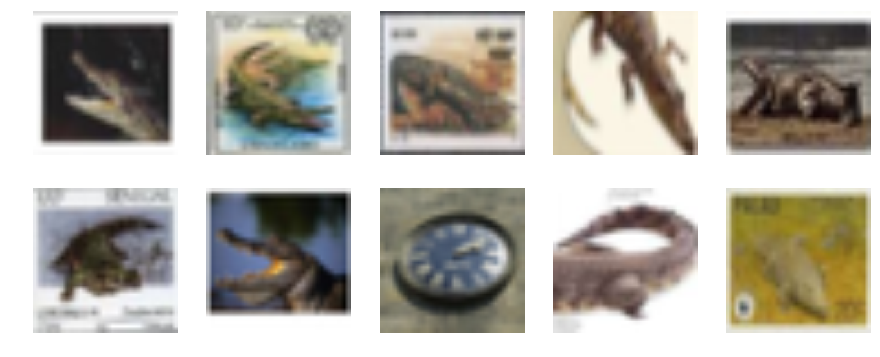

In [83]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))

for i in range(10):
    ax[i // 5][i % 5].imshow(raw_dataset[confidence_sorted[i]][0])
    ax[i // 5][i % 5].set_axis_off()

# Task 1.3

In [13]:
# code of Generator class taken from: https://github.com/EmilienDupont/wgan-gp/blob/master/models.py
class Generator(nn.Module):
    def __init__(self, img_size, latent_dim, dim):
        super(Generator, self).__init__()

        self.dim = dim
        self.latent_dim = latent_dim
        self.img_size = img_size
        self.feature_sizes = (self.img_size[0] // 16, self.img_size[1] // 16)

        self.latent_to_features = nn.Sequential(
            nn.Linear(latent_dim, 8 * dim * self.feature_sizes[0] * self.feature_sizes[1]),
            nn.ReLU()
        )

        self.features_to_image = nn.Sequential(
            nn.ConvTranspose2d(8 * dim, 4 * dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(4 * dim),
            nn.ConvTranspose2d(4 * dim, 2 * dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(2 * dim),
            nn.ConvTranspose2d(2 * dim, dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(dim),
            nn.ConvTranspose2d(dim, self.img_size[2], 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        # Map latent into appropriate size for transposed convolutions
        x = self.latent_to_features(input_data)
        # Reshape
        x = x.view(-1, 8 * self.dim, self.feature_sizes[0], self.feature_sizes[1])
        # Return generated image
        return self.features_to_image(x)

    def sample_latent(self, num_samples):
        return torch.randn((num_samples, self.latent_dim))
    
    
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.resnet = models.resnet18(pretrained=True)
        self.classifier = nn.Sequential()
        self.classifier.add_module('lin1', nn.Linear(1000, 256))
        self.classifier.add_module('bn1', nn.BatchNorm1d(256))
        self.classifier.add_module('relu1', nn.ReLU())
        self.classifier.add_module('lin2', nn.Linear(256, 2))
        
    
    def forward(self, x):
        x = self.resnet(x)
        x = F.sigmoid(self.classifier(x))
        return x
        

In [14]:
bce = nn.BCELoss()

def neg_entropy_loss(x):
    loss = x*torch.log(x)
    loss = (1-x)*torch.log(1-x)
    loss = loss.mean()
    return loss

def gen_loss(x):
    real_probs = x[:, 0]
    crock_probs = x[:, 1]
    
    entropy = neg_entropy_loss(crock_probs)
    fool_loss = - torch.log(real_probs).mean()
    
    return entropy + fool_loss

def d_loss_real(preds, targets):
    real_probs = preds[:, 0]
    crock_probs = preds[:, 1]
    
    clf_loss = bce(crock_probs, targets)
    inspect_loss = - torch.log(real_probs).mean()
    
    return clf_loss+inspect_loss
    
def d_loss_fake(preds):
    real_probs = preds[:, 0]
    crock_probs = preds[:, 1]
    
    return - torch.log(1 - real_probs).mean()

In [15]:
N_EPOCHS = 100
BATCH = 64

In [16]:
generator = Generator((224, 224, 3), 256, 128).cuda()
discriminator = Discriminator().cuda()

lr = 1e-4

g_optimizer = torch.optim.Adam(generator.parameters(),     lr=lr, betas=(0.5, 0.9))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.9))

In [19]:
def train_epoch_GAN(real_loader, generator, discriminator):
    generator.train()
    discriminator.train()
    
    for X_batch, y_batch in real_loader:
        
        X_var = Variable(X_batch).cuda()
        y_var = Variable(y_batch[:, None]).type(torch.FloatTensor).cuda()
        
        preds = discriminator(X_var)
        
        print(preds.shape)
        
        d_optimizer.zero_grad()
        loss = d_loss_real(preds, y_var)        
        loss.backward()
        d_optimizer.step()
        
        d_optimizer.zero_grad()
        latent = generator.sample_latent(BATCH)
        latent = Variable(latent).cuda()
        fake_data = generator(latent)
        preds = discriminator(fake_data)
        
        d_optimizer.zero_grad()
        d_loss = d_loss_fake(preds)
        d_loss.backward()
        d_optimizer.step()
        
        g_optimizer.zero_grad()
        g_loss = gen_loss(preds)
        g_loss.backward()
        g_optimizer.step()
        

In [20]:
for e in range(N_EPOCHS):
    train_epoch_GAN(full_loader, generator, discriminator)

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518243271935/work/torch/lib/THC/generic/THCStorage.cu:58